# Load package and data

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.svm import SVC, OneClassSVM
from sklearn.cluster import SpectralClustering, KMeans
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [2]:
feat_df = pd.read_pickle('working/feat_sample.pkl')
feat_df.head()

,filename,label,time_frequency,time_frequency_3d,cepstral_features
1068,data/fan/id_02/normal/00000810.wav,1,"[0.010177672, 0.012029049, 0.013606661, 0.0148...","[[[0.010177672, 0.012029049, 0.013606661, 0.01...","[1342.3212, -169.33577, 56.431564, -12.343427,..."
1371,data/fan/id_04/normal/00000679.wav,1,"[0.024199693, 0.023569148, 0.019138765, 0.0124...","[[[0.024199693, 0.023569148, 0.019138765, 0.01...","[2281.8855, -189.74542, 69.804276, -6.050237, ..."
2005,data/valve/id_06/normal/00000517.wav,1,"[0.0101727145, 0.011456816, 0.012681167, 0.013...","[[[0.0101727145, 0.011456816, 0.012681167, 0.0...","[756.97705, -236.23352, 26.00385, -2.6535478, ..."
981,data/fan/id_04/abnormal/00000188.wav,0,"[0.0080217095, 0.011077157, 0.01367029, 0.0154...","[[[0.0080217095, 0.011077157, 0.01367029, 0.01...","[235.9078, -155.51778, 32.71039, -6.1253037, 4..."
665,data/fan/id_04/normal/00000943.wav,1,"[0.0369246, 0.036855336, 0.03460157, 0.0312877...","[[[0.0369246, 0.036855336, 0.03460157, 0.03128...","[2645.254, -213.74278, 82.40141, -0.6766622, 1..."


In [5]:
with open('working/dump.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [6]:
filename= np.array(b['filename'])
label= np.array(b['label'])
cepstral_features=np.array(b['cepstral_features'])

In [7]:
time_frequency_3d=np.array(b['time_frequency_3d'])

In [8]:
time_frequency_3d.shape

(1000, 8, 610, 313)

In [9]:
time_frequency=time_frequency_3d.reshape(1000,8*610*313)

In [10]:
time_frequency.shape

(1000, 1527440)

In [18]:
time_freq = feat_df['time_frequency'].to_numpy().flatten()
time_freq.shape

(800,)

In [59]:
## on

dtype('O')

# Clustering

## Using UMAP

In [69]:
import umap
import umap.plot

In [70]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    scaler = StandardScaler()
    X=scaler.fit_transform(features)
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='euclidean',
                          n_components=2,
                          set_op_mix_ratio=0.35
                          ).fit(X)


    return embedding

In [71]:
 umap_cep_1 = get_scaled_umap_embeddings(cepstral_features2, 50, 0.1)

<AxesSubplot:>

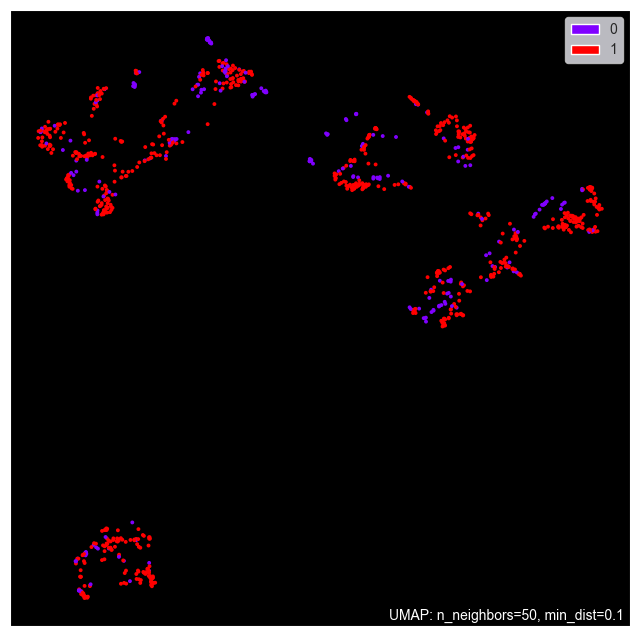

In [72]:
umap.plot.points(umap_cep_1, labels=label, color_key_cmap='Paired', theme='fire', background='black')

In [17]:
umap_time_1 = get_scaled_umap_embeddings(time_frequency, 50, 0.1)

<AxesSubplot:>

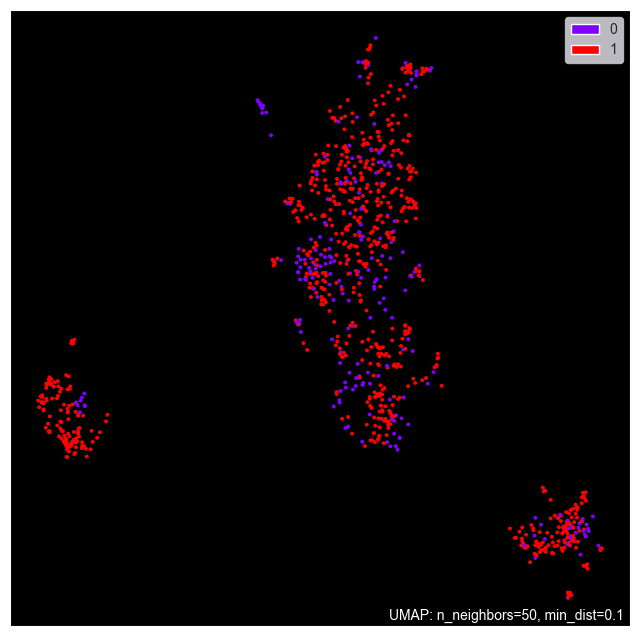

In [19]:
umap.plot.points(umap_time_1, labels=label, color_key_cmap='Paired', theme='fire', background='black')

In [71]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    scaler = StandardScaler()
    X=scaler.fit_transform(features)
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='euclidean',
                          n_components=2,
                          ).fit_transform(X)


    return embedding

In [ ]:
umap_embeddings_cepstral = []
umap_embeddings_time = []
neighbours = [5, 10, 15, 30, 50]
distances = [0.000, 0.001, 0.01, 0.1, 0.5]

for neighbour in neighbours:
    for distance in distances:
        umap_mfccs = get_scaled_umap_embeddings(cepstral_features,
                                                neighbour,
                                                distance)
        umap_embeddings_cepstral.append(umap_mfccs)

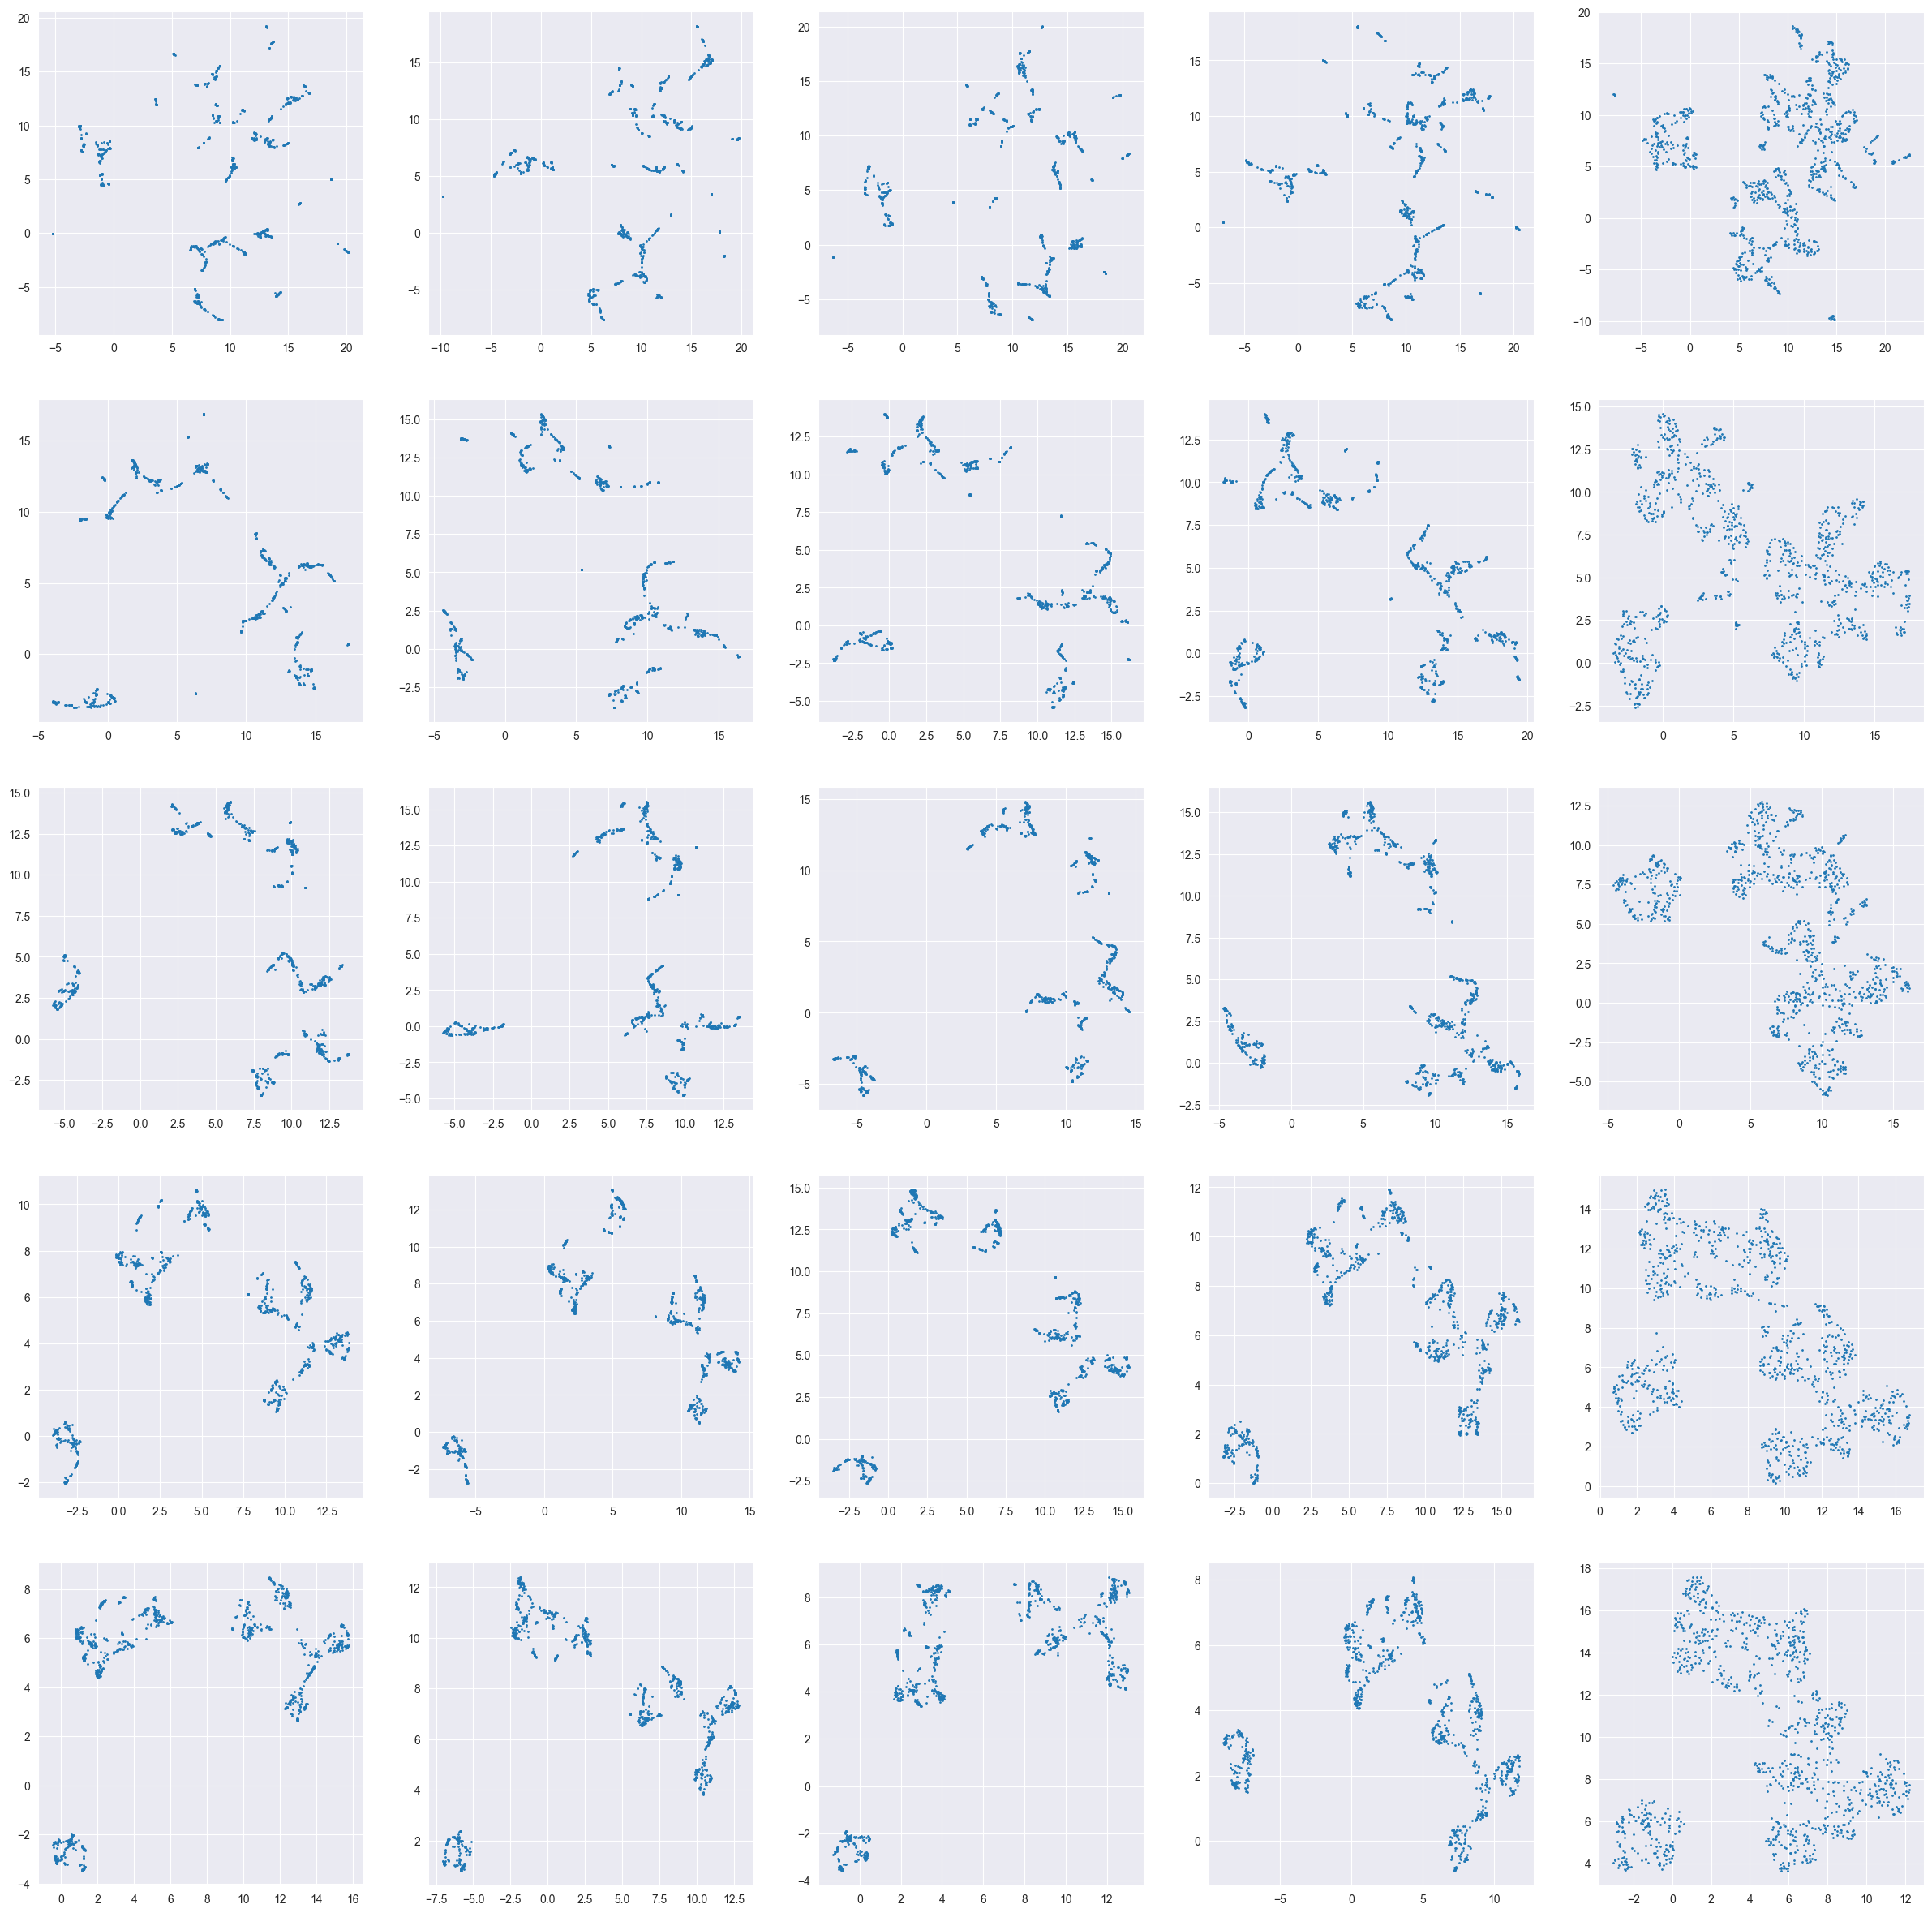

In [76]:
fig, ax = plt.subplots(nrows=len(neighbours),
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(distances) + j
        col.scatter(umap_embeddings_cepstral[current_plot].T[0],
                    umap_embeddings_cepstral[current_plot].T[1],
                    s=1)
plt.show()

In [21]:
umap_time_1.embedding_.shape

(1000, 2)

### try LOF on umap embeddings

In [22]:
import sklearn.neighbors

In [23]:
label.mean()

0.764

In [24]:
outlier_scores_t = sklearn.neighbors.LocalOutlierFactor(contamination=0.2).fit_predict(umap_time_1.embedding_)

In [39]:
outlier_scores_c = sklearn.neighbors.LocalOutlierFactor(contamination=0.2).fit_predict(umap_cep_1.embedding_)

In [40]:
outlier_scores_t.mean()

0.6

In [41]:
outlier_scores_c.mean()

0.6

In [45]:
outlying_label = label[outlier_scores_t == -1]

In [46]:
import collections

elements_count = collections.Counter(outlying_label)
# printing the element and the frequency
for key, value in elements_count.items():
    print(f"{key}: {value}")

1: 130
0: 70


In [63]:
cepstral_features

array([[ 1.2950316e+03, -1.7215292e+02,  5.0014908e+01, ...,
         5.2460812e-02,  4.7225136e-02, -2.4442622e-01],
       [ 2.6666667e+03, -2.6869031e+02,  1.0138776e+02, ...,
         2.6786375e+00,  4.1155653e+00, -9.8820227e-01],
       [ 2.6776331e+02, -2.8483450e+02,  3.8686871e+01, ...,
        -2.1363764e+00,  7.7465022e-01,  6.6682596e+00],
       ...,
       [ 2.6666667e+03, -1.9393938e+02,  3.9238564e+01, ...,
         1.1696194e+00,  1.9598402e+00, -1.7383674e+00],
       [ 2.5095159e+03, -2.5453246e+02,  2.0825329e+01, ...,
        -1.2681066e+00, -1.6764977e+00, -1.8667483e+00],
       [ 2.6666667e+03, -3.3267447e+02,  7.8988815e+01, ...,
        -3.8509205e-01, -4.3560523e-01,  7.5378615e-01]], dtype=float32)

In [65]:
cepstral_features2=np.delete(cepstral_features, 0, axis=1)

## Svm

In [66]:
# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    cepstral_features2, label, test_size=0.2, random_state=42
)

In [67]:
# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

Accuracy on the test set with raw data: 0.905


In [55]:
# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    umap_cep_1.embedding_, label, test_size=0.2, random_state=42
)

In [56]:
# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

Accuracy on the test set with raw data: 0.745


In [50]:
# Transformation with UMAP followed by classification with a linear SVM
umap = umap.UMAP(random_state=456)
pipeline = Pipeline([("umap", umap), ("svc", svc)])
params_grid_pipeline = {
    "umap__n_neighbors": [5, 20],
    "umap__n_components": [15, 25, 50],
    "svc__C": [10 ** k for k in range(-3, 4)],
}

In [52]:
clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline)
clf_pipeline.fit(X_train, y_train)
print(
    "Accuracy on the test set with UMAP transformation: {:.3f}".format(
        clf_pipeline.score(X_test, y_test)    )
)


C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\P

Accuracy on the test set with UMAP transformation: 0.785


# Try feature selection

In [73]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score

# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have a full-blown estimator

clf = Pipeline(
    [
        ("anova", SelectPercentile(f_classif)),
        ("scaler", StandardScaler()),
        ("svc", SVC(gamma="auto")),
    ]
)

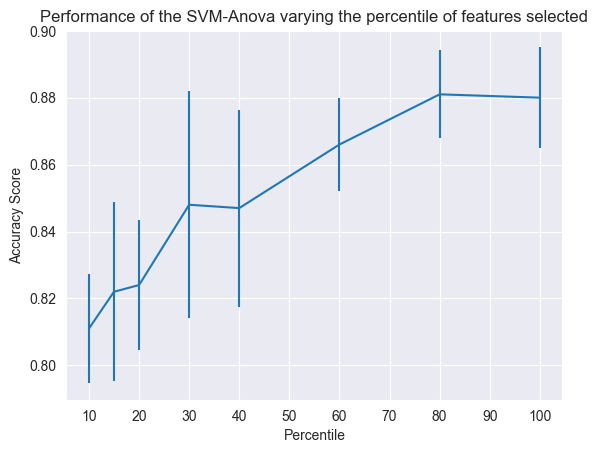

In [74]:
score_means = list()
score_stds = list()
percentiles = (10, 15, 20, 30, 40, 60, 80, 100)
X=cepstral_features
y=label
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()